# Setup

In [ ]:
%pip install pymysql
%pip install sshtunnel
%pip install pandas

In [1]:
import pymysql
from sshtunnel import SSHTunnelForwarder
import paramiko
from os.path import expanduser
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import math

home = expanduser('~')
mypkey = paramiko.RSAKey.from_private_key_file( home + "/.ssh/id_rsa")

sql_hostname = '127.0.0.1'
sql_username = 'readonly'
sql_password = None
sql_main_database = 'ML3_mirror'
sql_port = 3306
ssh_host = 'flagon.cs.umn.edu'
ssh_user = 'kanna128'
ssh_port = 22
sql_ip = '1.1.1.1.1'

def SSH_connection(query):
  with SSHTunnelForwarder(
        (ssh_host, ssh_port),
        ssh_username=ssh_user,
        ssh_pkey=mypkey,
        remote_bind_address=(sql_hostname, sql_port)) as tunnel:
    conn = pymysql.connect(host='127.0.0.1', user=sql_username,
                            passwd=sql_password, db=sql_main_database,
                            port=tunnel.local_bind_port)
    # print('connection done')
    df_result = pd.read_sql_query(query,conn)
  
  return df_result

In [3]:
# def remove_rows(df, desired_diff):
#     alt_df = df
#     # rows = alt_df.shape[0]
#     # for k in range(rows):
#     #     firstLogin = alt_df.loc[k].at['firstLogin']
#     #     lastLogin = alt_df.loc[k].at['lastLogin']
#     #     diff = lastLogin - firstLogin

#     #     if diff.days>desired_diff:
#     #         alt_df = alt_df.drop(k, 0)
    
#     for index, row in alt_df.iterrows():
#         diff = row['lastLogin'] - row['firstLogin']
#         if diff.days<desired_diff:
#             alt_df = alt_df.drop(index, 0)

#     return alt_df

global vars

In [2]:
BASELINE = "{\"engineId\":\"baseline\"}"
ITEM_ITEM = "{\"engineId\":\"item-item\"}"
SVD = "{\"engineId\":\"svd\"}"
PICK_GROUPS = "{\"engineId\":\"pick-groups\"}"

LONG_TO_SHORT = {BASELINE: "baseline", ITEM_ITEM: "item-item", SVD:"svd", PICK_GROUPS: "pick-groups"}
SHORT_TO_LONG = {"baseline": BASELINE, "item-item":ITEM_ITEM, "svd":SVD, "pick-groups":PICK_GROUPS}

primary_dicts()

In [3]:
def primary_dicts(users, change_events, fields):
    
    uid = fields[0]
    initial_val = fields[1]

    user_id_keys = users[uid].to_list()
    pattern_list_dict = {key: [ SHORT_TO_LONG[initial_val] ] for key in user_id_keys}
    # pattern_list_dict = dict.fromkeys(user_id_keys, [ SHORT_TO_LONG[initial_val] ]) # key=userId, val=curralg in the iteration process


    changes_dict = {} # key=userId, val=number of rec changes
    cmp_field = fields[2]
    
    # loop to count number of changes correctly; comparing next with prev algorithm
    for index,row in change_events.iterrows():
        userId = row[uid]
        item_to_cmp = row[cmp_field]
        if(pattern_list_dict[userId][-1] != item_to_cmp):
            changes_dict[userId] = 1 + changes_dict.get(userId, 0)
            pattern_list_dict[userId].append(item_to_cmp)

    return (changes_dict, pattern_list_dict)

# Queries

change_events

In [5]:
query_changes = ''' SELECT userId, action, tstamp, logJson from ML3_mirror.log_action WHERE EXISTS
                  (SELECT userId from user_data WHERE firstLogin<'2015-12-01' AND firstLogin>'2013-12-01' AND user_data.userId = log_action.userId)
                  AND tstamp>='2015-11-04' AND tstamp<'2016-04-01'  AND action='recommender-change' '''
change_events = SSH_connection(query_changes)
print("Rec changes: ", change_events.shape[0])

Rec changes:  14030


In [6]:
query_changes_days = ''' SELECT userId, action, tstamp, logJson from ML3_mirror.log_action WHERE EXISTS
                  (SELECT userId, DATEDIFF(lastLogin, firstLogin)+1 as diff from user_data WHERE firstLogin<'2015-12-01' 
                  AND firstLogin>'2013-12-01' AND user_data.userId = log_action.userId
                  HAVING diff>=100)
                  AND tstamp>='2015-11-04' AND tstamp<'2016-04-01'  AND action='recommender-change' '''
change_events_days = SSH_connection(query_changes_days)
print("Rec changes days: ", change_events_days.shape[0])

Rec changes days:  7480


In [50]:
#TEST
for index,row in change_events.iterrows():
    if row['userId'] == 271900:
        print(row)

userId                       271900
action           recommender-change
tstamp          2015-11-04 00:02:21
logJson    {"engineId":"item-item"}
Name: 1, dtype: object
userId                         271900
action             recommender-change
tstamp            2015-11-04 00:02:49
logJson    {"engineId":"pick-groups"}
Name: 2, dtype: object
userId                         271900
action             recommender-change
tstamp            2015-11-04 00:02:49
logJson    {"engineId":"pick-groups"}
Name: 3, dtype: object
userId                       271900
action           recommender-change
tstamp          2015-11-04 00:03:38
logJson    {"engineId":"item-item"}
Name: 4, dtype: object


first_logs

In [7]:
# query_first_logs = ''' SELECT userId, action, MIN(tstamp) as tstamp from ML3_mirror.log_action WHERE EXISTS
#                   (SELECT userId from user_data WHERE firstLogin<'2015-12-01' AND firstLogin>='2013-12-01' AND user_data.userId = log_action.userId)
#                   AND tstamp>='2015-11-04' AND tstamp<'2016-04-01' GROUP BY log_action.userId '''
query_first_logs = ''' SELECT la.userId, la.action, MIN(la.tstamp) as tstamp FROM ML3_mirror.log_action la 
                       INNER JOIN ML3_mirror.user_data ud ON ud.userId=la.userId
                       AND ud.firstLogin<'2015-12-01' AND ud.firstLogin>='2013-12-01' 
                       AND la.tstamp>='2015-11-04' AND la.tstamp<'2016-04-01' GROUP BY la.userId '''
first_logs = SSH_connection(query_first_logs)
print(first_logs.shape[0])
first_logs.head()

#9m 50.5s
#53.5s

6697


,userId,action,tstamp
0,244830,pageview,2015-11-04 00:35:31
1,244847,pageview,2015-11-17 13:54:33
2,244860,pageview,2016-03-07 14:36:31
3,244940,pageview,2015-11-08 05:00:12
4,244955,pageview,2016-01-12 22:38:33


In [6]:
#TEST
query = ''' SELECT userId, DATEDIFF(lastLogin, firstLogin)+1 as diff from user_data WHERE firstLogin<'2015-12-01' AND
            firstLogin>='2013-12-01' HAVING diff>=100 '''
df = SSH_connection(query)
df.head()

connection done


,userId,diff
0,244777,180
1,244815,481
2,244817,3148
3,244838,153
4,244841,377


In [5]:
query_logs_days = ''' SELECT userId, action, tstamp from ML3_mirror.log_action WHERE EXISTS 
                  (SELECT userId, DATEDIFF(lastLogin, firstLogin)+1 as diff from user_data WHERE firstLogin<'2015-12-01' AND 
                  firstLogin>='2013-12-01' AND log_action.userId=user_data.userId HAVING diff>=100)
                  AND tstamp>='2015-11-04' AND tstamp<'2016-04-01' '''
user_logs_days = SSH_connection(query_logs_days)
user_logs_days.head()

# 2m 34.3s

connection done


,userId,action,tstamp
0,271892,pageview,2015-11-04 00:00:12
1,271892,pageview,2015-11-04 00:00:22
2,271454,pageview,2015-11-04 00:00:28
3,271892,pageview,2015-11-04 00:00:39
4,271454,pageview,2015-11-04 00:00:45


In [16]:
query_flogs_days = ''' SELECT userId, action, MIN(tstamp) as tstamp from ML3_mirror.log_action WHERE EXISTS 
                  (SELECT userId, DATEDIFF(lastLogin, firstLogin)+1 as diff from user_data WHERE firstLogin<'2015-12-01' AND 
                  firstLogin>='2013-12-01' AND log_action.userId=user_data.userId HAVING diff>=100)
                  AND tstamp>='2015-11-04' AND tstamp<'2016-04-01' GROUP BY userId '''
first_logs_days = SSH_connection(query_flogs_days)
first_logs_days.shape[0]
first_logs_days.head()

connection done


,userId,action,tstamp
0,244830,pageview,2015-11-04 00:35:31
1,244847,pageview,2015-11-17 13:54:33
2,244860,pageview,2016-03-07 14:36:31
3,244940,pageview,2015-11-08 05:00:12
4,244955,pageview,2016-01-12 22:38:33


In [17]:
print(first_logs_days.shape[0])

3431


query_logs_sessions

In [8]:
# query_logs_sessions = ''' SELECT userId, action, tstamp from ML3_mirror.log_action WHERE EXISTS 
#                   (SELECT userId from user_data WHERE firstLogin<'2015-12-01' AND firstLogin>='2013-12-01' AND log_action.userId=user_data.userId) 
#                   AND tstamp>='2015-11-04' AND tstamp<'2016-04-01' '''
query_logs_sessions = ''' SELECT la.userId, la.action, la.tstamp FROM ML3_mirror.log_action la INNER JOIN ML3_mirror.user_data ud
                          ON ud.userId=la.userId WHERE ud.firstLogin<'2015-12-01' AND ud.firstLogin>='2013-12-01' 
                          AND la.tstamp>='2015-11-04' AND la.tstamp<'2016-04-01' '''
user_logs_sessions = SSH_connection(query_logs_sessions)
user_logs_sessions.head()

#2m 54.4s
#1m 13.8s

,userId,action,tstamp
0,271897,rating,2015-11-04 00:00:00
1,271464,pageview,2015-11-04 00:00:00
2,271869,rating,2015-11-04 00:00:02
3,271897,pageview,2015-11-04 00:00:02
4,271464,rating,2015-11-04 00:00:05


In [9]:
first_logs_tstamps = first_logs.set_index('userId').to_dict()['tstamp']
# print(type(user_logs_sessions['userId'].to_list()))

In [10]:
# print("Days:", user_logs_days.shape[0])
print("Sessions: ", user_logs_sessions.shape[0])

Sessions:  1210234


query_rcount

In [10]:
query_rcount = ''' SELECT la.userId, COUNT(la.action) as rating_count FROM ML3_mirror.log_action la
                   INNER JOIN ML3_mirror.user_data ud ON ud.userId=la.userId 
                   WHERE ud.firstLogin<'2015-12-01' AND ud.firstLogin>='2013-12-01'
                   AND la.tstamp>='2015-11-04' AND la.tstamp<'2016-04-01' AND la.action='rating'
                   GROUP BY la.userId HAVING rating_count>=20 '''
ratings_count = SSH_connection(query_rcount)
# ratings_count.head()
print("Size: ", ratings_count.shape[0])

#22.9s

Size:  3130


# Funcs and output

session_count()

In [11]:
def session_count(user_logs, tstamps_dict, fields):
    id_field = fields[0]
    time_field = fields[1]

    sessions_dict = {}

    for index,row in user_logs.iterrows():
        unique_id = row[id_field]
        diff = row[time_field] - tstamps_dict[unique_id]
        if diff.total_seconds() > 3600:
            sessions_dict[unique_id] = 1 + sessions_dict.get(unique_id, 1)
        else:
            sessions_dict[unique_id] = sessions_dict.get(unique_id, 1)
        tstamps_dict[unique_id] = row[time_field]
    
    return sessions_dict

rcount_queries()

In [12]:
def rcount_queries(upper_bound):
    query = ''' SELECT la.userId, COUNT(la.action) as rating_count FROM ML3_mirror.log_action la
                INNER JOIN ML3_mirror.user_data ud ON ud.userId=la.userId 
                WHERE ud.firstLogin<'2015-12-01' AND ud.firstLogin>='2013-12-01'
                AND la.tstamp>='2015-11-04' AND la.tstamp<'2016-04-01' AND la.action='rating'
                GROUP BY la.userId HAVING rating_count>={} '''.format(upper_bound)
    rcounts = SSH_connection(query)
    rcounts_dict = rcounts.set_index('userId').to_dict()['rating_count']

    return rcounts_dict

results

In [13]:
sessions_count = session_count(user_logs_sessions, first_logs_tstamps, ('userId', 'tstamp'))
sessions_count_new = {key:val for key,val in sessions_count.items() if val>=2}
print(max(sessions_count_new.values()))
print(min(sessions_count_new.values()))
print("Users who had a minimum of two sessions between 2015-11-04 and 2016-04-01: ",len(sessions_count_new.values()))
print("Users who used the system between 2015-11-04 and 2016-04-01 and their lastLogin-firstLogin is in range: ",len(sessions_count.values()))

512
2
Users who had a minimum of two sessions between 2015-11-04 and 2016-04-01:  3346
Users who used the system between 2015-11-04 and 2016-04-01 and their lastLogin-firstLogin is in range:  6697


In [14]:
dicts = primary_dicts(first_logs, change_events, ('userId', "pick-groups", 'logJson'))
dict1 = dicts[0]

# print("firstLogin is between 2013 and 2015; have entries between 2015/11 and 2016/03 in log_action ")
# print("Users: ", len(sessions_count))
# print("All users who have switched recommenders: ", len(dict1.values()), "(",(len(dict1.values())/6697)*100, "% )")
# print("Total rec change events for the same users: ", sum(dict1.values()))
# print("")

temp = dict1
dict1 = {key:val for key,val in dict1.items() if key in sessions_count_new.keys()}
print("firstLogin is between 2013 and 2015; have entries between 2015/11 and 2016/03 in log_action; minimum of two sessions in the time period of interest ")
print("Users: ", len(sessions_count_new))
print("Users of interest who have switched recommenders: ", len(dict1.values()),"(",(len(dict1.values())/3346)*100, "% )")
print("Total rec change events for these users: ",sum(dict1.values()))
print("")

dict1_alt = temp
ratings_dict = ratings_count.set_index('userId').to_dict()['rating_count']
dict1_alt = {key:val for key,val in dict1_alt.items() if key in ratings_dict.keys()}
print("Users: ", len(ratings_dict))
print("Users who switched recommenders: ", len(dict1_alt.values()), "(",(len(dict1_alt.values())/3130)*100, "% )" )
print("Total rec change events: ", sum(dict1_alt.values()))

firstLogin is between 2013 and 2015; have entries between 2015/11 and 2016/03 in log_action; minimum of two sessions in the time period of interest 
Users:  3346
Users of interest who have switched recommenders:  1615 ( 48.26658696951584 % )
Total rec change events for these users:  5990

Users:  3130
Users who switched recommenders:  2382 ( 76.10223642172525 % )
Total rec change events:  6744


In [17]:
percentages = []
for k in range(20, 101, 20):
    dict_out = rcount_queries(k)
    rec_changes = {key:val for key,val in temp.items() if key in dict_out.keys()}
    percentages.append( (len(rec_changes.values())/len(dict_out)) * 100 )
    print("loop ", k)
print(percentages)     

loop  20
loop  40
loop  60
loop  80
loop  100
[72.6517571884984, 75.3339269813001, 76.49164677804295, 78.69955156950674, 80.65395095367847]


# Figures and tables

additional funcs

In [22]:
def fig_3(recchange_dict, changes_list):
    # count_dict: key=algorithm, val=(no. of users initially assigned, no. of users initially assigned and switched at least once)
    count_dict = {"baseline":[0,0], "item-item":[0,0], "svd":[0,0], "pick-groups":[0,0]}
    for userId,recalg_list in recchange_dict.items():
        recalg = LONG_TO_SHORT[recalg_list[0]]
        count_dict[recalg][0] +=1
        if userId in changes_list:
            count_dict[recalg][1] += 1
    
    baseline = count_dict["baseline"][1]/count_dict["baseline"][0]
    item_item = count_dict["item-item"][1]/count_dict["item-item"][0]
    svd = count_dict["svd"][1]/count_dict["svd"][0]

    values = [["baseline", "item-item", "svd"], [baseline, item_item, svd], 0.01]
    return (count_dict, values)

def fig_4(changes_dict, range):
    transitions_dict = {}

    lower_bound = range[0]
    upper_bound = range[1]
    for list in changes_dict.values():
        transition_count = len(list) - 1
        if transition_count>lower_bound and transition_count<upper_bound: 
            transitions_dict[transition_count] = 1 + transitions_dict.get(transition_count, 0)
    return transitions_dict

In [16]:
def draw_graph(values, labels, max_vals, scale):
  bars = plt.bar(range(len(values[1])), values[1], color=(0.2, 0.4, 0.6, 0.6))

  if((isinstance(scale[1], int))):
    for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + 0.5*bar.get_width(), yval + values[2], yval)

  xticks = []
  yticks = []

  if(scale[0] != 0):
    xmax = max_vals[0]
    xscale = scale[0]
    for k in np.arange(0, xmax, xscale):
      xticks.append(k)
    plt.xticks(xticks)
  else:
    plt.xticks(range(len(values[0])), values[0])
  
  ymax = max_vals[1]
  yscale = scale[1]

  for k in np.arange(0, ymax, yscale):
    yticks.append(k)
  plt.yticks(yticks)

  plt.xlabel(labels[0])
  plt.ylabel(labels[1])
  plt.ylim(0,max_vals[1])

  if(max_vals[0] != 0):
    plt.xlim(0, max_vals[0])
  
  plt.show()

fig 3

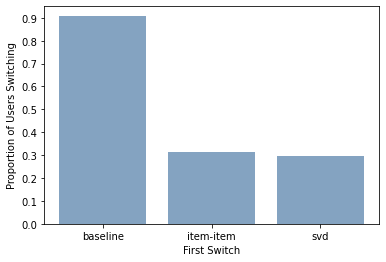

In [19]:
pattern_list_dicts = dicts[1]
pattern_list_dicts = {key:val for key,val in pattern_list_dicts.items() if key in ratings_dict.keys()}

pattern_list_dicts_new = {key:val[1:] for key,val in pattern_list_dicts.items() }
pattern_list_dicts_new = {key:val for key,val in pattern_list_dicts_new.items() if len(val)>0}

changes_list = [key for key,val in pattern_list_dicts_new.items() if len(val)>1]

fig_2_vars = fig_3(pattern_list_dicts_new, changes_list)

draw_graph(fig_2_vars[1], ["First Switch", "Proportion of Users Switching"], [0, 0.95], [0, 0.1])



fig 2

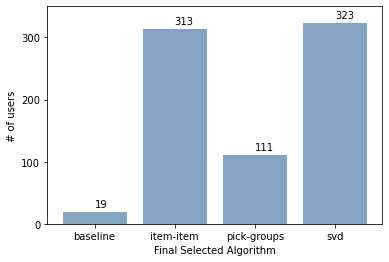

In [21]:
count_dict = {key:0 for key in fig_2_vars[0].keys()}

for userId, recalg_list in pattern_list_dicts.items():
    if(userId in changes_list):
        count_dict[ LONG_TO_SHORT[recalg_list[-1]] ] += 1

values = [["baseline", "item-item", "pick-groups", "svd"], 
        [count_dict["baseline"], count_dict["item-item"], 
        count_dict["pick-groups"], count_dict["svd"]], 
        8]
draw_graph(values, ["Final Selected Algorithm", "# of users"], [0, 350], [0, 100])

fig 4

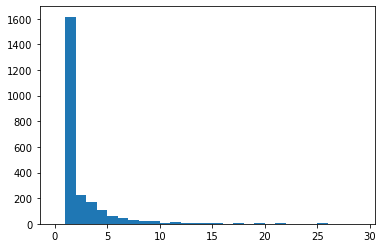

In [26]:
# FIGURE 4
func_out = fig_4(pattern_list_dicts, (0, 27))
plt.hist(func_out.keys(), weights=func_out.values(), bins = range(30))
plt.show()

In [45]:
dicts_days = primary_dicts(first_logs_days, change_events_days, ('userId', "pick-groups", 'logJson'))
dict1_days = dicts_days[0]

print("firstLogin is between 2013 and 2015; have entries between 2015/11 and 2016/03 in log_action; used the system for at least 100 days ")
print("Users: ", first_logs_days.shape[0])
print("All users who have switched recommenders: ", len(dict1_days.values()), "(",(len(dict1_days.values())/3431)*100, "% )")
print("Total rec change events for the same users: ", sum(dict1_days.values()))

# dict1 = {key:val for key,val in dict1.items() if val!=0}
# print("All users who switched at least once: ", len(dict1.values()))

# have I possibly found evidence that leans towards why picking users who used the system for 100 days or more could mean that 
# they could've performed many actions, including recommender changes, outside of the time period of interest (2015/11 - 2016/03)?

# are these results useful in the context of analyzing recommender changes within the time period of interest?

# defining a group of users who are active | using ratings/ those who logged in a certain number of times within the observation period
# is the minimum number really arbitrary? | sensitivity analysis

firstLogin is between 2013 and 2015; have entries between 2015/11 and 2016/03 in log_action; used the system for at least 100 days 
Users:  3431
All users who have switched recommenders:  1237 ( 36.053628679685225 % )
Total rec change events for the same users:  4591
